--- 数据准备完成，预览如下 ---
            log_ret_brent  log_ret_wti
date                                  
1987-05-21      -0.009709     0.010076
1987-05-22       0.005405    -0.013626
1987-05-26       0.001612    -0.016910
1987-05-27      -0.001612     0.001549
1987-05-28       0.000000    -0.005173


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


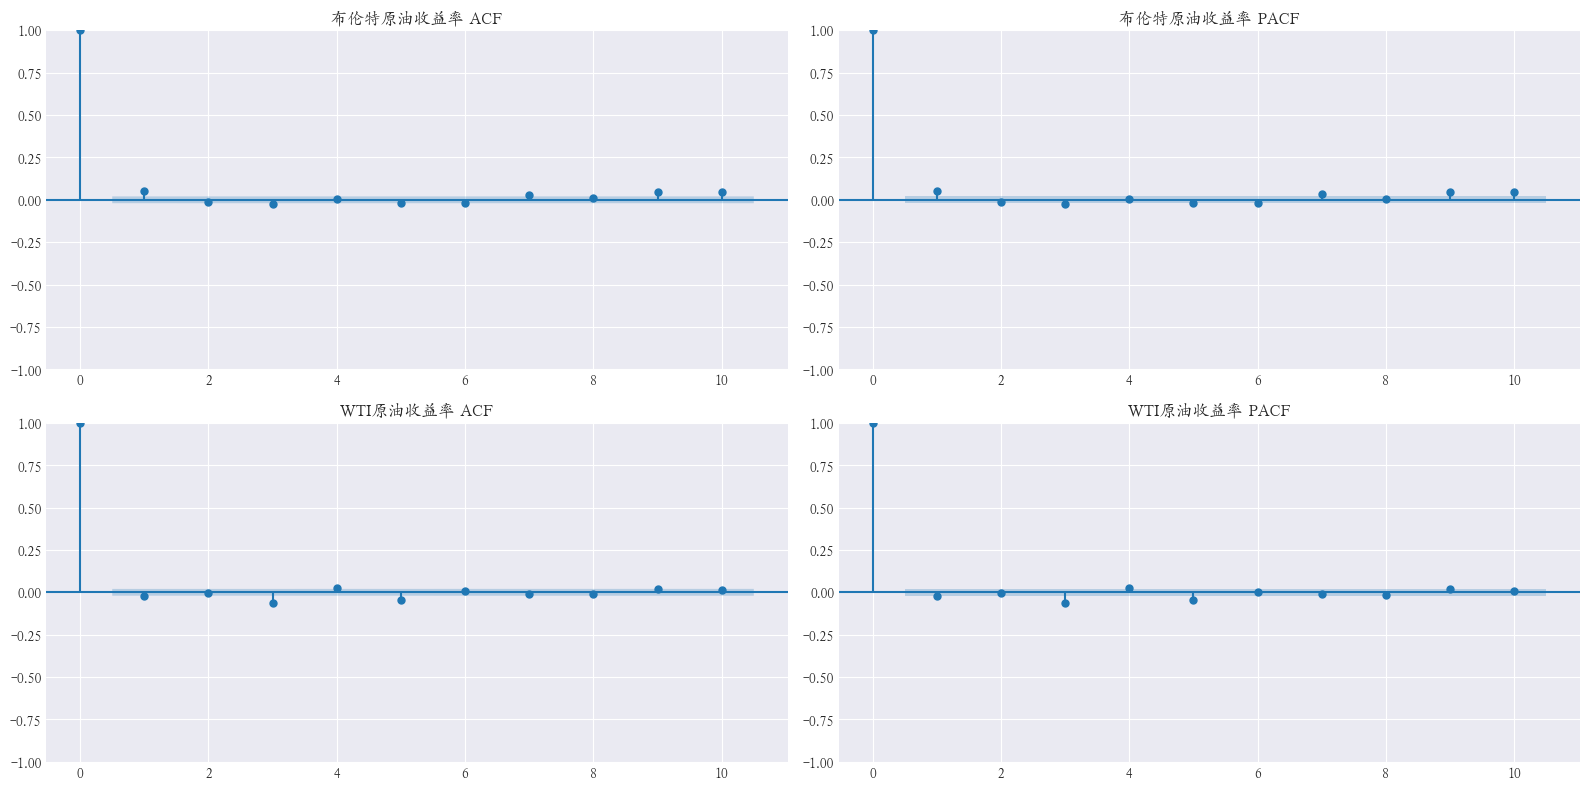

In [4]:
# --- 第1步：导入库并准备数据 ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 设置Matplotlib样式和中文字体
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['font.sans-serif'] = ['Kai']
plt.rcParams['axes.unicode_minus'] = False

# --- 加载、清洗和预处理数据的函数 ---
def prepare_oil_data(brent_path='RBRTEd.csv', wti_path='RWTCd.csv'):
    """加载、清洗并合并原油数据，返回包含对数收益率的DataFrame。"""
    brent_df = pd.read_csv(brent_path, usecols=[0, 1])
    brent_df.columns = ['date', 'brent_price']
    wti_df = pd.read_csv(wti_path, usecols=[0, 1])
    wti_df.columns = ['date', 'wti_price']

    # 转换日期格式
    brent_df['date'] = pd.to_datetime(brent_df['date'], format='%b %d, %Y')
    wti_df['date'] = pd.to_datetime(wti_df['date'], format='%b %d, %Y')

    brent_df.set_index('date', inplace=True)
    wti_df.set_index('date', inplace=True)

    # 清洗价格数据
    brent_df['brent_price'] = pd.to_numeric(brent_df['brent_price'], errors='coerce')
    wti_df['wti_price'] = pd.to_numeric(wti_df['wti_price'], errors='coerce')

    brent_df.dropna(inplace=True)
    wti_df.dropna(inplace=True)

    # 计算对数收益率
    brent_df['log_ret'] = np.log(brent_df['brent_price']).diff()
    wti_df['log_ret'] = np.log(wti_df['wti_price']).diff()

    brent_df.dropna(inplace=True)
    wti_df.dropna(inplace=True)

    # 合并数据
    merged_df = pd.merge(brent_df[['log_ret']], wti_df[['log_ret']],
                         left_index=True, right_index=True,
                         suffixes=('_brent', '_wti'))
    return merged_df

# 执行数据准备
data = prepare_oil_data()
print("--- 数据准备完成，预览如下 ---")
print(data.head())


# --- 第2步：观察ACF/PACF图，进行模型定阶 ---
# 金融时间序列的自相关通常是短期的，我们重点关注前10个滞后阶
fig, axes = plt.subplots(2, 2, figsize=(16, 8))

# 布伦特原油
plot_acf(data['log_ret_brent'], lags=10, ax=axes[0, 0], title='布伦特原油收益率 ACF')
plot_pacf(data['log_ret_brent'], lags=10, ax=axes[0, 1], title='布伦特原油收益率 PACF')

# WTI原油
plot_acf(data['log_ret_wti'], lags=10, ax=axes[1, 0], title='WTI原油收益率 ACF')
plot_pacf(data['log_ret_wti'], lags=10, ax=axes[1, 1], title='WTI原油收益率 PACF')

plt.tight_layout()
plt.show()

In [5]:
# --- 第3步：模型拟合与分析 ---

# 划分训练集和测试集（这里我们用99%的数据做训练，因为数据量很大）
train_size = int(len(data) * 0.99)
train_brent = data['log_ret_brent'].iloc[:train_size]
train_wti = data['log_ret_wti'].iloc[:train_size]


# --- 为布伦特原油拟合模型 ---
print("\n" + "="*30)
print(" 布伦特原油 (Brent) 模型分析")
print("="*30)

# 拟合AR(2)模型
# ARIMA(p,d,q) 中 d=0 表示我们使用的是收益率（已经差分过的平稳序列）
model_brent_ar2 = ARIMA(train_brent, order=(2, 0, 0)).fit()
print("\n--- Brent AR(2) 模型摘要 ---")
print(model_brent_ar2.summary())

# 拟合MA(2)模型
model_brent_ma2 = ARIMA(train_brent, order=(0, 0, 2)).fit()
print("\n--- Brent MA(2) 模型摘要 ---")
print(model_brent_ma2.summary())

# 拟合ARMA(2,2)模型
model_brent_arma22 = ARIMA(train_brent, order=(2, 0, 2)).fit()
print("\n--- Brent ARMA(2,2) 模型摘要 ---")
print(model_brent_arma22.summary())


# --- 为WTI原油拟合模型 ---
print("\n" + "="*30)
print(" WTI 原油模型分析")
print("="*30)

# 拟合AR(2)模型
model_wti_ar2 = ARIMA(train_wti, order=(2, 0, 0)).fit()
print("\n--- WTI AR(2) 模型摘要 ---")
print(model_wti_ar2.summary())

# 拟合MA(2)模型
model_wti_ma2 = ARIMA(train_wti, order=(0, 0, 2)).fit()
print("\n--- WTI MA(2) 模型摘要 ---")
print(model_wti_ma2.summary())

# 拟合ARMA(2,2)模型
model_wti_arma22 = ARIMA(train_wti, order=(2, 0, 2)).fit()
print("\n--- WTI ARMA(2,2) 模型摘要 ---")
print(model_wti_arma22.summary())

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



 布伦特原油 (Brent) 模型分析

--- Brent AR(2) 模型摘要 ---
                               SARIMAX Results                                
Dep. Variable:          log_ret_brent   No. Observations:                 9470
Model:                 ARIMA(2, 0, 0)   Log Likelihood               21768.495
Date:                Wed, 15 Oct 2025   AIC                         -43528.991
Time:                        15:50:06   BIC                         -43500.367
Sample:                             0   HQIC                        -43519.276
                               - 9470                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.833      0.405      -0.000       0.001
ar.L1          0.0517      0.005     10.435      0.000       0.042       0.061
ar.L2

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



--- Brent MA(2) 模型摘要 ---
                               SARIMAX Results                                
Dep. Variable:          log_ret_brent   No. Observations:                 9470
Model:                 ARIMA(0, 0, 2)   Log Likelihood               21768.135
Date:                Wed, 15 Oct 2025   AIC                         -43528.270
Time:                        15:50:06   BIC                         -43499.647
Sample:                             0   HQIC                        -43518.555
                               - 9470                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.828      0.407      -0.000       0.001
ma.L1          0.0516      0.005     10.412      0.000       0.042       0.061
ma.L2         -0.0130     

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



--- Brent ARMA(2,2) 模型摘要 ---
                               SARIMAX Results                                
Dep. Variable:          log_ret_brent   No. Observations:                 9470
Model:                 ARIMA(2, 0, 2)   Log Likelihood               21770.241
Date:                Wed, 15 Oct 2025   AIC                         -43528.482
Time:                        15:50:07   BIC                         -43485.547
Sample:                             0   HQIC                        -43513.909
                               - 9470                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.829      0.407      -0.000       0.001
ar.L1         -0.0683      0.265     -0.258      0.797      -0.588       0.451
ar.L2         -0.3101 

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



--- WTI AR(2) 模型摘要 ---
                               SARIMAX Results                                
Dep. Variable:            log_ret_wti   No. Observations:                 9470
Model:                 ARIMA(2, 0, 0)   Log Likelihood               20988.746
Date:                Wed, 15 Oct 2025   AIC                         -41969.492
Time:                        15:50:07   BIC                         -41940.869
Sample:                             0   HQIC                        -41959.777
                               - 9470                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.568      0.570      -0.000       0.001
ar.L1         -0.0234      0.004     -5.370      0.000      -0.032      -0.015
ar.L2         -0.0032      0

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



--- WTI MA(2) 模型摘要 ---
                               SARIMAX Results                                
Dep. Variable:            log_ret_wti   No. Observations:                 9470
Model:                 ARIMA(0, 0, 2)   Log Likelihood               20988.808
Date:                Wed, 15 Oct 2025   AIC                         -41969.615
Time:                        15:50:07   BIC                         -41940.992
Sample:                             0   HQIC                        -41959.900
                               - 9470                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.000      0.563      0.574      -0.000       0.001
ma.L1         -0.0212      0.004     -4.870      0.000      -0.030      -0.013
ma.L2         -0.0068      0

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWar


--- WTI ARMA(2,2) 模型摘要 ---
                               SARIMAX Results                                
Dep. Variable:            log_ret_wti   No. Observations:                 9470
Model:                 ARIMA(2, 0, 2)   Log Likelihood               20988.802
Date:                Wed, 15 Oct 2025   AIC                         -41965.605
Time:                        15:50:09   BIC                         -41922.670
Sample:                             0   HQIC                        -41951.032
                               - 9470                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.000      0.541      0.589      -0.000       0.001
ar.L1         -0.0118      5.806     -0.002      0.998     -11.392      11.368
ar.L2         -0.0018   